# NeuralProphet Tutorial 😇🙏🏻

<i>Prepared by Zhoya Marie Ginez and Mavel Paderes</i>

We prepared this notebook as part of the requirements for the Time Series Analysis (TSA) course of the Masters of Science in Data Science Program (MSDS) at the Asian Institute of Management (AIM). This notebook only serves to get one started in using the NeuralProphet package and not as a detailed comprehensive guide to all of its methods and parameters.<br>

Other resources related to NeuralProphet are as follows:
* [NeuralProphet documentation](https://neuralprophet.com/html/contents.html)
* [GitHub repository](https://github.com/ourownstory/neural_prophet)
* Paper: <i>[NeuralProphet: Explainable Forecasting at Scale](https://arxiv.org/abs/2111.15397?fbclid=IwAR2vCkHYiy5yuPPjWXpJgAJs-uD5NkH4liORt1ch4a6X_kmpMqagGtXyez4)</i>

---

Before anything else, install the NeuralProphet package with `pip`:

In [ ]:
!pip install neuralprophet

If you are going to use the package in a Jupyter notebook, the creators of NeuralProphet recommend to install the "live" version as well:

In [ ]:
!pip install neuralprophet[live]

The following are the libraries that will be used in the rest of this notebook.

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pickle

from neuralprophet import NeuralProphet, set_log_level
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import livelossplot

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'figure.figsize': (15, 5)})

## Introduction
---
NeuralProphet is a hybrid forecasting framework based on PyTorch, making it easy for developers to extend the framework. Local context is introduced with auto-regression and covariate modules, which can be configured as classical linear regression or as Neural Networks. Otherwise, NeuralProphet retains the design philosophy of Prophet and provides the same basic model components.<br>

For this tutorial, we will be forecasting the price of gold in USD; we also attempt to use the NYSE index as a covariate. The datasets used are [Global Gold Price](https://www.kaggle.com/datasets/jishnukoliyadan/gold-price-1979-present?select=Daily_Gold_Price_on_World.csv) and [Stock Exchange Data](https://www.kaggle.com/datasets/mattiuzc/stock-exchange-data).<br>

Note 1: `NYA` is the ticker of the NYSE index.<br>
Note 2: We limit our data to 30 years, i.e., from 1990 to 2019.

In [3]:
df_gold = pd.read_csv("data/Daily_Gold_Price_on_World.csv")
df_stocks = pd.read_csv("data/indexData.csv")

# filter dates
gold = df_gold[(df_gold['Date'] >= "1990-01-01") & 
               (df_gold['Date'] <= "2019-12-31")]
gold = gold.iloc[:, :2]

stocks = df_stocks[(df_stocks['Date'] >= "1990-01-01") & 
                   (df_stocks['Date'] <= "2019-12-31") & 
                   (df_stocks['Index'] == "NYA")]

Let's look at the first five rows of both the `gold` and `stocks` dataframes.

In [5]:
gold.head(5)

,Date,US dollar (USD)
2870,1990-01-01,398.6
2871,1990-01-02,399.0
2872,1990-01-03,395.0
2873,1990-01-04,396.5
2874,1990-01-05,405.0


In [4]:
stocks.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
6034,NYA,1990-01-02,2093.600098,2093.600098,2093.600098,2093.600098,2093.600098,0.0
6035,NYA,1990-01-03,2091.479980,2091.479980,2091.479980,2091.479980,2091.479980,0.0
6036,NYA,1990-01-04,2075.520020,2075.520020,2075.520020,2075.520020,2075.520020,0.0
6037,NYA,1990-01-05,2058.070068,2058.070068,2058.070068,2058.070068,2058.070068,0.0
6038,NYA,1990-01-08,2065.370117,2065.370117,2065.370117,2065.370117,2065.370117,0.0


Note that 37% of the `Volume` column is zero, so let's not use this as a covariate.

In [6]:
r = len(stocks)
z = (stocks.Volume == 0).sum()

print(f"No. of rows:                  {r}")
print(f"No. of rows with zero volume: {z} "
      f"==> {int(round(100*z/r,0))}% of total")

No. of rows:                  7559
No. of rows with zero volume: 2799 ==> 37% of total


Moreover, not surprisingly, all of the covariates in the `stocks` dataframe are collinear. Thus, to simplify matters, let's limit the covariate to the average of the `Low` and `High` columns. Let's create a new column for the average....

In [7]:
stocks["ave_index"] = stocks[["Low", "High"]].mean(axis=1)
stocks.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,ave_index
6034,NYA,1990-01-02,2093.600098,2093.600098,2093.600098,2093.600098,2093.600098,0.0,2093.600098
6035,NYA,1990-01-03,2091.479980,2091.479980,2091.479980,2091.479980,2091.479980,0.0,2091.479980
6036,NYA,1990-01-04,2075.520020,2075.520020,2075.520020,2075.520020,2075.520020,0.0,2075.520020
6037,NYA,1990-01-05,2058.070068,2058.070068,2058.070068,2058.070068,2058.070068,0.0,2058.070068
6038,NYA,1990-01-08,2065.370117,2065.370117,2065.370117,2065.370117,2065.370117,0.0,2065.370117


And combine the `gold` and `stocks` dataframes into one.

<div class="alert alert-block alert-info">
    <b>Note:</b> NeuralProphet requires the date and target variable columns to be named <tt>ds</tt> and <tt>y</tt>, respectively. Moreover, it requires the columns to be ordered as follows: <tt>ds</tt> first, then all exogenous variables (i.e., covariates), then <tt>y</tt></div>

In [8]:
cols = ["Date", "ave_index", "US dollar (USD)"]

df_comb = pd.merge(gold, stocks, on=['Date'])[cols]
df_comb.rename(columns={'Date': 'ds', 'US dollar (USD)': 'y'}, inplace=True)
df_comb

,ds,ave_index,y
0,1990-01-02,2093.600098,399.00
1,1990-01-03,2091.479980,395.00
2,1990-01-04,2075.520020,396.50
3,1990-01-05,2058.070068,405.00
4,1990-01-08,2065.370117,404.60
...,...,...,...
7554,2019-12-24,13894.259765,1482.10
7555,2019-12-26,13918.379885,1482.10
7556,2019-12-27,13953.380370,1511.50
7557,2019-12-30,13908.675290,1514.75


Let's examine the plot for both gold prices and NYSE index.

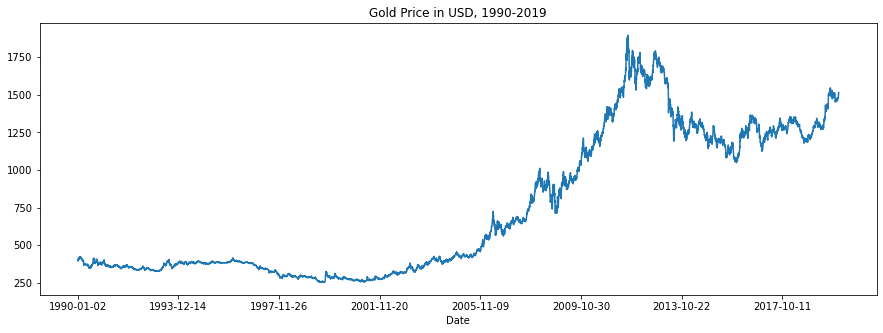

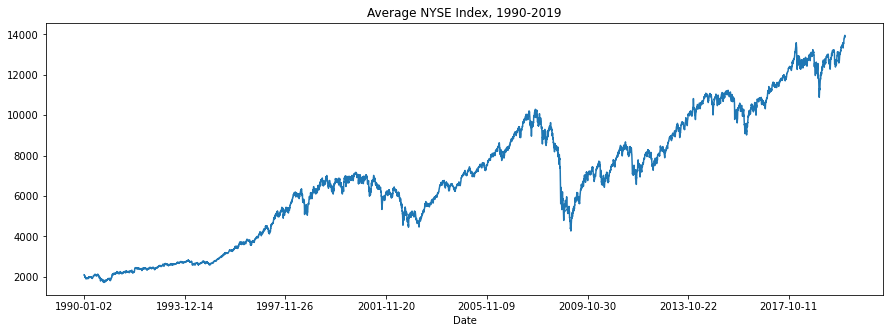

In [9]:
df_comb.plot('ds', 'y', legend=False)
plt.title("Gold Price in USD, 1990-2019")
plt.xlabel("Date")
plt.autoscale()
plt.show()

df_comb.plot('ds', 'ave_index', legend=False)
plt.title("Average NYSE Index, 1990-2019")
plt.xlabel("Date")
plt.autoscale()
plt.show()

## Baseline Model
---
<p style='text-align: justify;'>Let's first see how well an out-of-the-box model performs.</p>

### Train Model

In [10]:
m = NeuralProphet()

The <b>`split_df()`</b> method of NeuralProphet splits the time series dataframe into train and validation sets. The `valid_p` parameter is the fraction of data to use for holdout validation set. Note that the value used below, $0.2$, is the default value of this parameter.

Other options for splitting are <b>`crossvalidation_split_df()`</b> which splits the data in $k$ folds for crossvalidation, and <b>`double_crossvalidation_split_df()`</b> which splits data in two sets of $k$ folds for crossvalidation on validation and test data.

<div class="alert alert-block alert-info">
<b>Note:</b> If no lagged regressors will be used, the data that will be fed to the model should be a two-column pandas dataframe: <tt>ds</tt> and <tt>y</tt>. Otherwise, it will result in an error.</div>

In [11]:
df_train, df_test = m.split_df(df_comb[['ds', 'y']], freq='D', valid_p=0.2)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.521% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


A notable parameter of the `fit()` method is <b>`progress`</b> which enables live loss plotting during training when it is set to <b>`plot`</b>. As of the creation of this notebook, you can only successfully utilize this parameter if <b>neuralprophet[live]</b> is also installed.

The default for this parameter is <b>`bar`</b> which will display a live progress bar (`tqdm`).

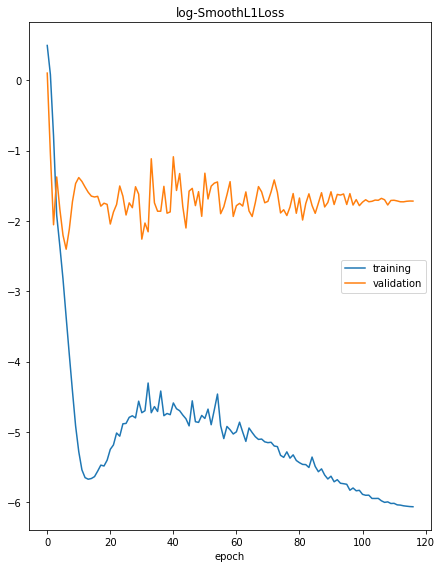

log-SmoothL1Loss
	training         	 (min:   -6.064, max:    0.495, cur:   -6.064)
	validation       	 (min:   -2.402, max:    0.102, cur:   -1.718)


In [12]:
metrics = m.fit(df_train, freq='D', validation_df=df_test, progress='plot')

The following are the error metrics in the last epoch.

<div class="alert alert-block alert-info">
<b>Note:</b> Smooth L1-Loss, also known as the Huber loss, is the default loss function.</div>

In [13]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
116,0.002326,48.984257,89.369109,0.0,0.179477,796.98607,809.36789


### Forecast

Given the plot of the training and validation loss, the model obviously didn't fit well out of the box, but let's try to forecast anyway for the sake of completing the pipeline.

In [14]:
forecast = m.predict(df_test)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.294% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.294% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2013-12-31,1204.50,1687.004639,482.504639,1131.468994,0.290217,555.245483
1,2014-01-02,1225.00,1688.877686,463.877686,1132.157227,1.984778,554.735718
2,2014-01-03,1234.50,1688.533203,454.033203,1132.501221,2.869493,553.162354
3,2014-01-06,1246.25,1692.113892,445.863892,1133.533569,5.622616,552.957642
4,2014-01-07,1227.50,1695.681763,468.181763,1133.877686,6.558650,555.245483


Let's now plot the forecasts.

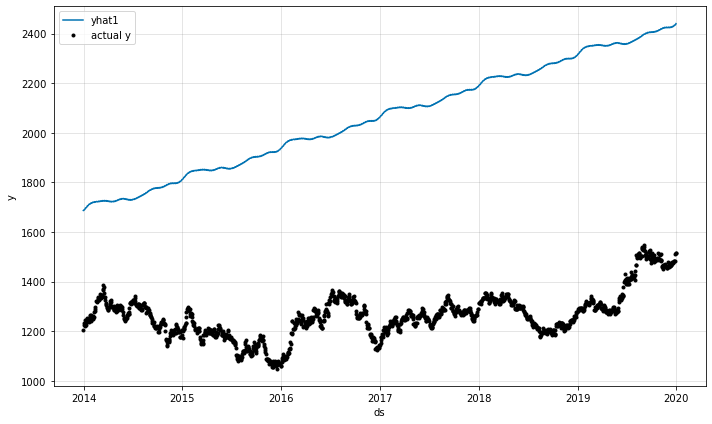

In [15]:
fig = m.plot(forecast)

As expected from the loss plot in the previous section, the forecasts are nowhere near the actual values—the forecasts actually exhibit an upward linear trend.

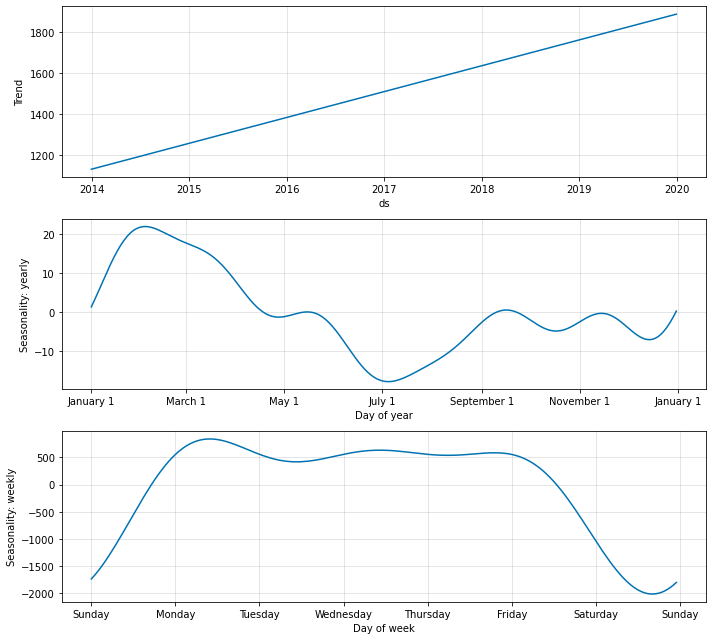

In [16]:
fig_comp = m.plot_components(forecast)

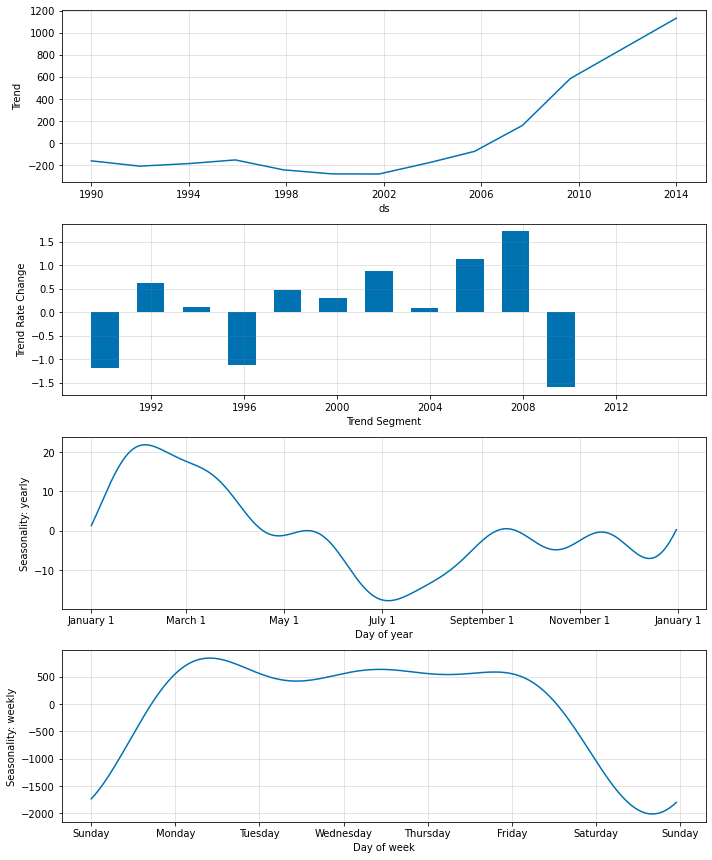

In [17]:
fig_param = m.plot_parameters()

## 3-steps ahead AR Model
---

This time, let's try an AR model that predicts three steps ahead.

### Train Model

We now set a few parameters in `NeuralProphet()`.
* The `n_forecasts` parameter is the forecast horizon. We want to forecast three steps ahead, so we set this parameter to 3.
* The `n_lags` parameter is the order $p$ of the AR($p$) model.

<div class="alert alert-block alert-info">
<b>Note:</b> In their paper, the creators said that the AR order "is commonly set to twice the innermost periodicity or <u>twice the forecast horizon</u>.</div>

Note that the `learning_rate` parameter can also be set here, but this time, we chose to continue to let NeuralProphet set the optimal learning rate in training.

In [86]:
m = NeuralProphet(n_forecasts=3, n_lags=2*3)

In [75]:
df_train, df_test = m.split_df(df_comb[['ds', 'y']], freq='D', valid_p=0.2)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.521% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 3397 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 3397 NaN values in column y were auto-imputed.


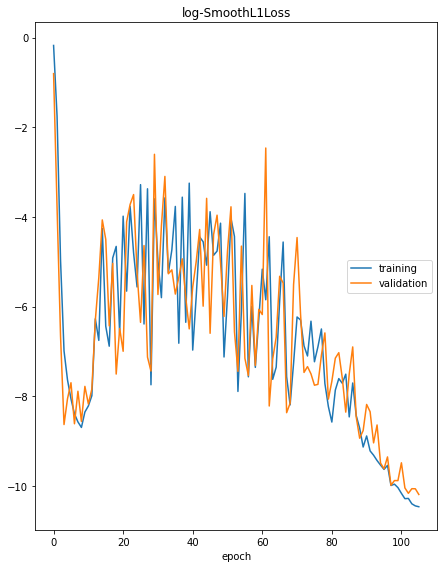

log-SmoothL1Loss
	training         	 (min:  -10.462, max:   -0.177, cur:  -10.462)
	validation       	 (min:  -10.188, max:   -0.805, cur:  -10.188)


In [87]:
metrics = m.fit(df_train, freq='D', validation_df=df_test, progress='plot')

In [88]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
105,0.000029,5.318651,9.835225,0.0,0.000038,8.537077,11.807723


### Forecast

In [89]:
forecast = m.predict(df_test)
forecast.head(10)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.955% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,ar1,ar2,ar3,trend,season_yearly,season_weekly
0,2013-12-26,1199.000000,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None
1,2013-12-27,1214.500000,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None
2,2013-12-28,1211.166667,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None
3,2013-12-29,1207.833333,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None
4,2013-12-30,1204.500000,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None
5,2013-12-31,1204.500000,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None
6,2014-01-01,1214.750000,1203.38269,-11.36731,None,NaN,None,NaN,948.219727,None,None,255.620728,-0.278992,-0.178734
7,2014-01-02,1225.000000,1211.47168,-13.52832,1202.936157,-22.063843,None,NaN,956.499756,947.964233,None,255.619171,-0.180235,-0.467077
8,2014-01-03,1234.500000,1222.023438,-12.476562,1211.975708,-22.524292,1203.831055,-30.668945,966.637512,956.589783,948.445129,255.617615,-0.080065,-0.151675
9,2014-01-04,1238.416667,1232.425293,-5.991374,1222.719482,-15.697184,1212.675171,-25.741496,976.638,966.93219,956.887939,255.616058,0.020838,0.150286


The model seems to fit the test data well!

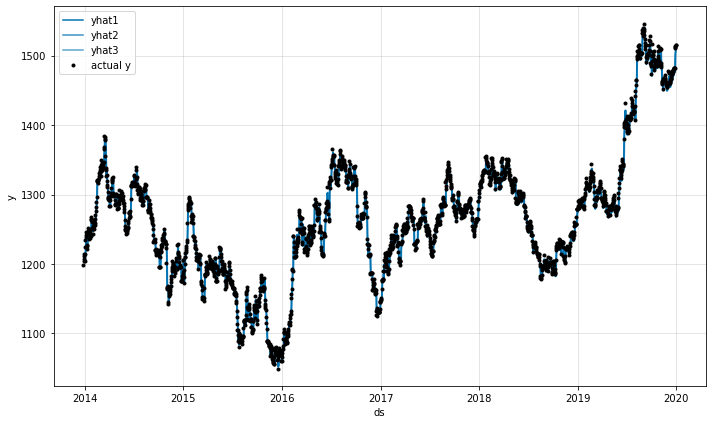

In [90]:
fig = m.plot(forecast)

Let's zoom in in the last six months.

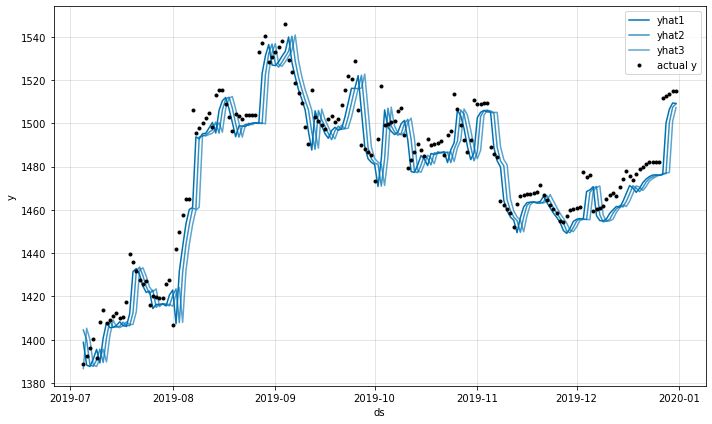

In [91]:
fig = m.plot(forecast[-180:])

It's a bit difficult to parse the forecast plots above, but we can take a closer look at a particular forecast horizon by highlighting the $n$-th step ahead of each forecast. We chose to focus on the gold price predicted 3 days ahead, which is the most distant prediction into the future.

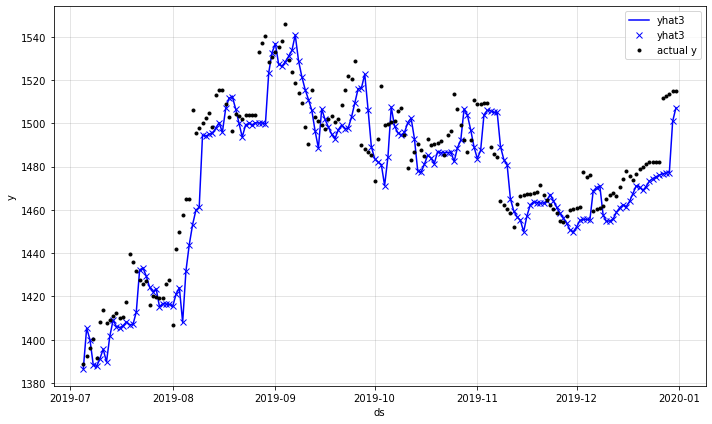

In [92]:
m = m.highlight_nth_step_ahead_of_each_forecast(3)
fig = m.plot(forecast[-180:])

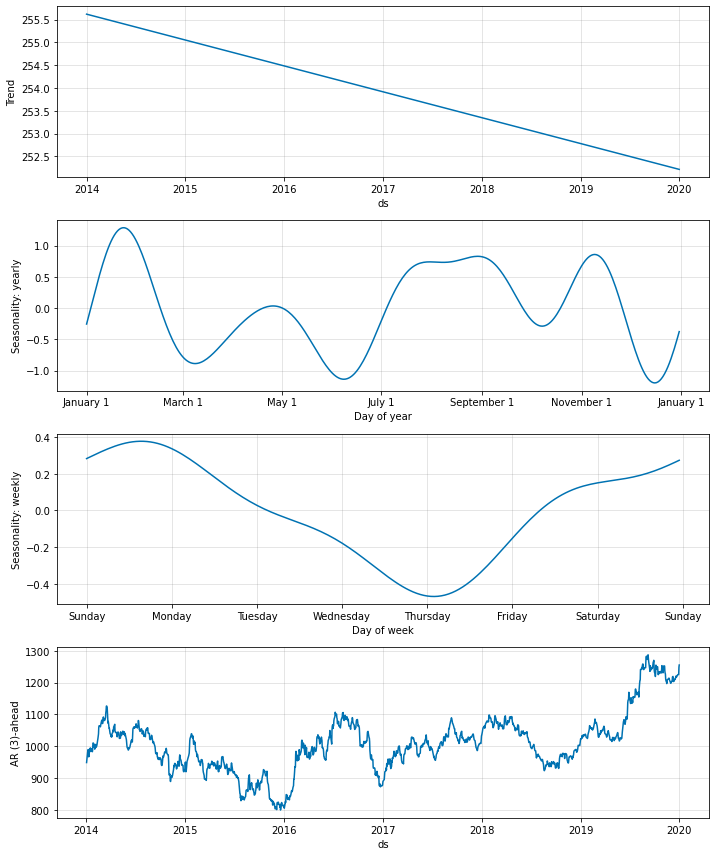

In [93]:
fig_comp = m.plot_components(forecast)

The panel "AR weight" below shows the weight given to the six last observed values; these are essentially our AR coefficients. We can see that the $t-1$ values have the greatest weight in a predicted value.

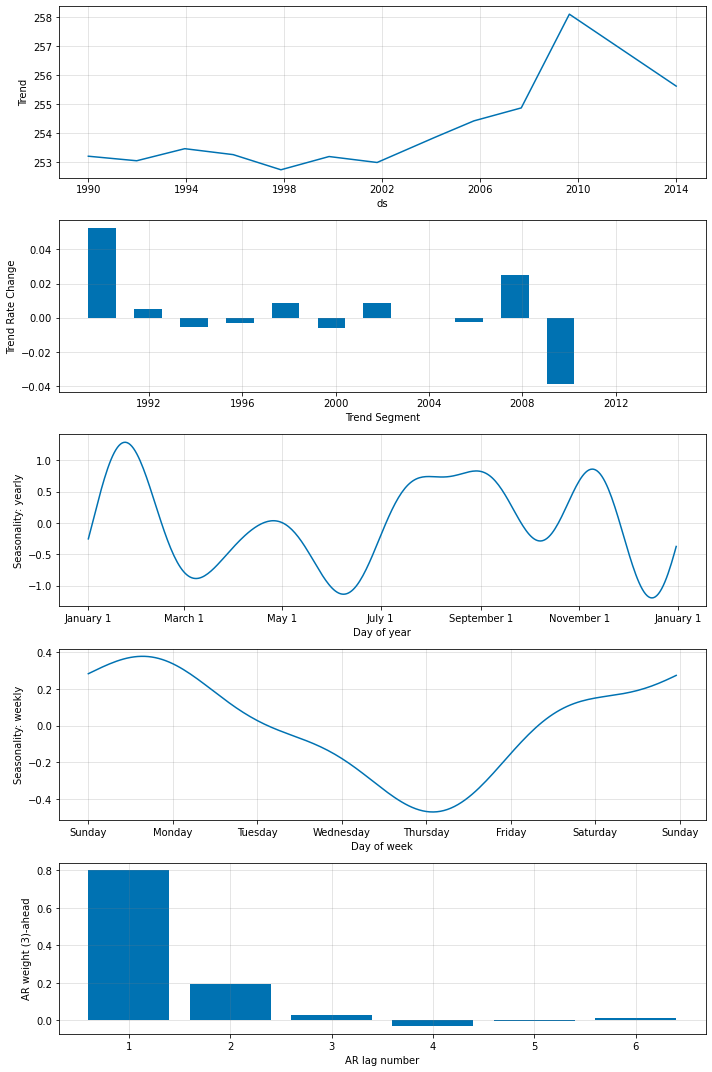

In [94]:
fig_param = m.plot_parameters()

## 3-steps ahead AR and Lagged Regressors Model
---
Let's now try adding a lagged covariate to the model, specifically the average NYSE index.

### Train Model

In [96]:
m = NeuralProphet(n_forecasts=3, n_lags=2*3, learning_rate=0.1)

Store the column names of the covariates in a list and use the <b>`add_lagged_regressor()`</b> method to add this as a lagged regressor to the model.

In [97]:
ex_var = ["ave_index"]

m = m.add_lagged_regressor(names=ex_var, 
                           normalize='auto') # auto in normalize is a default

NeuralProphet can also automatically handle country-specific holidays. Since we are looking at US prices, let's add US holidays to the model. This can be done with the <b>`add_country_holidays()`</b> method.

In [98]:
m = m.add_country_holidays("US")

In [99]:
df_train, df_test = m.split_df(df_comb, freq='D', valid_p=0.2)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.521% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 3397 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 3397 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 3397 NaN values in column ave_index were auto-imputed.


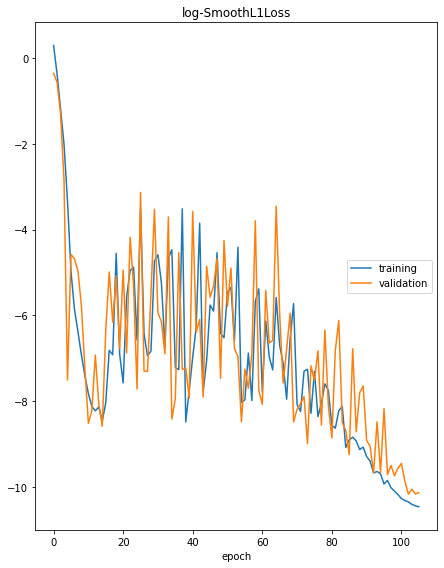

log-SmoothL1Loss
	training         	 (min:  -10.465, max:    0.297, cur:  -10.465)
	validation       	 (min:  -10.169, max:   -0.351, cur:  -10.136)


In [100]:
metrics = m.fit(df_train, freq='D', validation_df=df_test, progress='plot')

In [101]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
105,0.000029,5.407954,9.769347,0.0,0.00004,8.880151,12.132109


### Forecast

In [102]:
forecast = m.predict(df_test)
forecast.head(10)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.955% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,ar1,ar2,...,event_Independence Day (Observed),event_Labor Day,event_Martin Luther King Jr. Day,event_Memorial Day,event_New Year's Day,event_New Year's Day (Observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (Observed),event_Washington's Birthday
0,2013-12-26,1199.000000,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2013-12-27,1214.500000,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2013-12-28,1211.166667,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2013-12-29,1207.833333,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2013-12-30,1204.500000,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
5,2013-12-31,1204.500000,None,NaN,None,NaN,None,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
6,2014-01-01,1214.750000,1205.422974,-9.327026,None,NaN,None,NaN,947.894653,None,...,0.0,0.0,0.0,0.0,3.19781,0.0,0.0,0.0,0.0,0.0
7,2014-01-02,1225.000000,1210.608398,-14.391602,1202.69104,-22.30896,None,NaN,957.010925,947.809082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2014-01-03,1234.500000,1222.842773,-11.657227,1213.044189,-21.455811,1204.644409,-29.855591,967.302673,957.025452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2014-01-04,1238.416667,1232.566528,-5.850138,1221.595581,-16.821086,1211.233276,-27.18339,976.699463,967.065002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


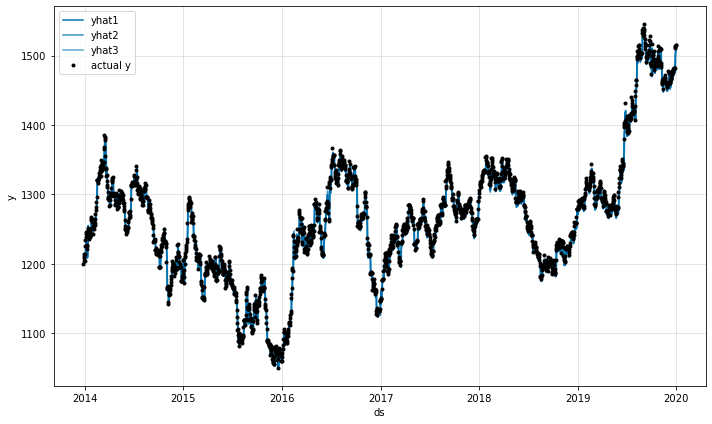

In [103]:
fig = m.plot(forecast)

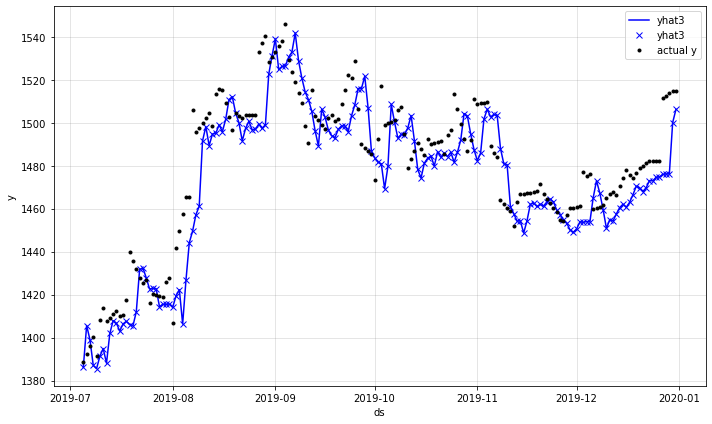

In [105]:
m = m.highlight_nth_step_ahead_of_each_forecast(3)
fig = m.plot(forecast[-180:])

The above plot does not seem much different from the forecast plot produced from the <i>3-steps ahead AR model</i>. In fact, the decrease in the error metrics are very small. Thus, it does not seem that adding lagged covariates as well as US holidays improves the model by a lot.

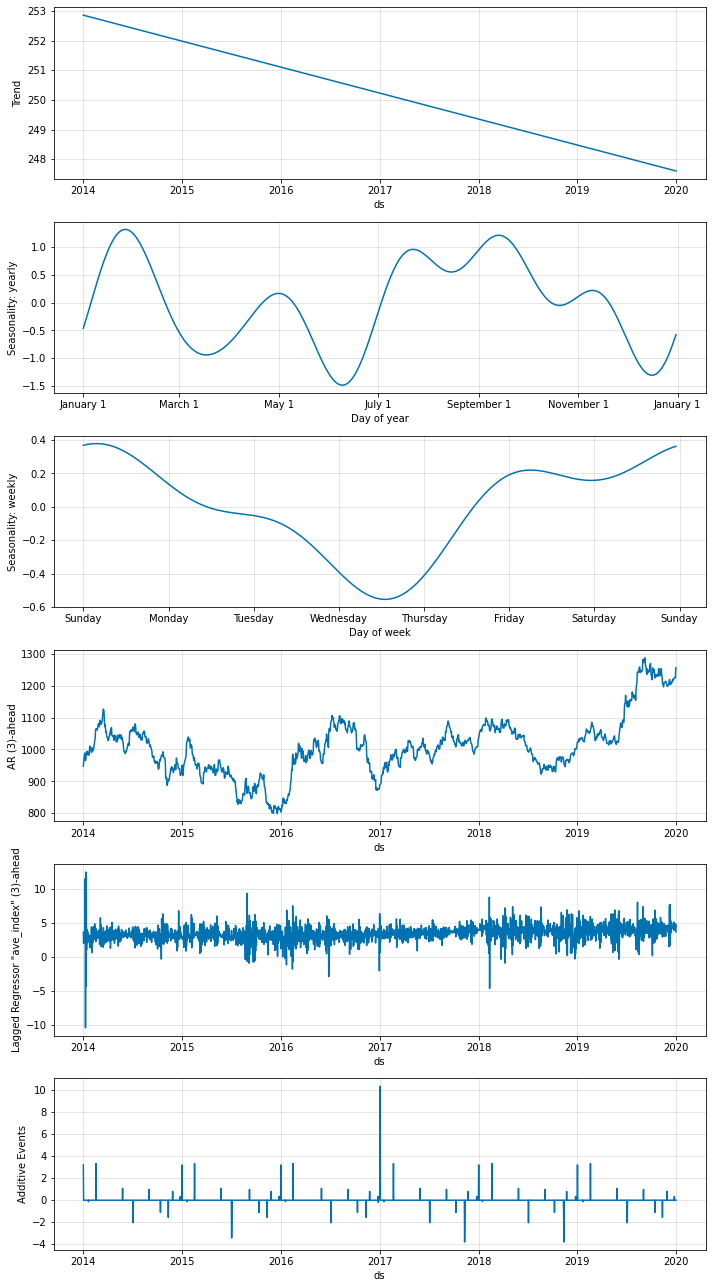

In [106]:
fig_comp = m.plot_components(forecast)

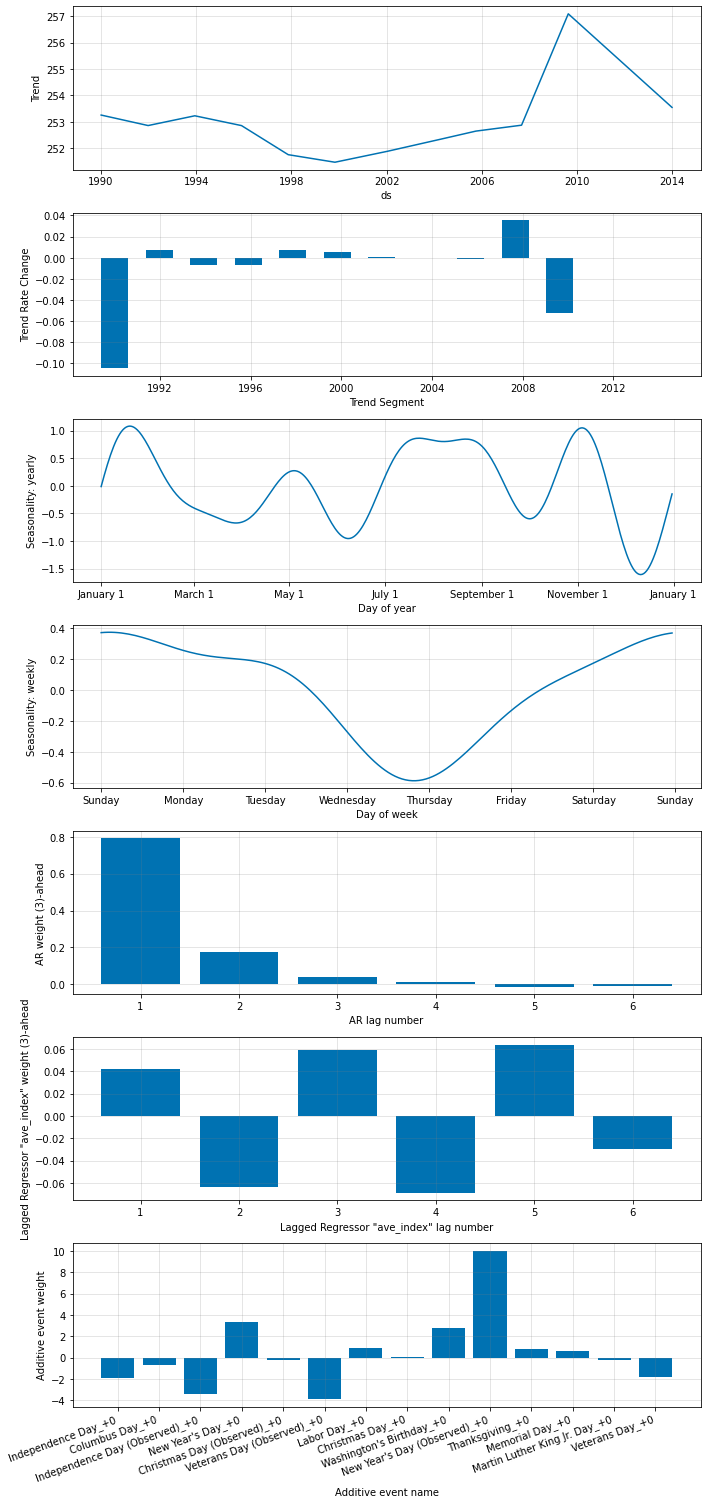

In [62]:
fig_param = m.plot_parameters()

## 30-steps ahead Neural Model with Long AR and Lagged Regressors
---
Finally, let's see how a neural model will perform.

### Train Model

We added a few parameters to use the NN module of NeuralProphet. Specifically:
* The `num_hidden_layers` parameter control the number of hidden layers in the neural network.
* The `d_hidden` parameter is the number of nodes in each hidden layer.

<div class="alert alert-block alert-info">
<b>Note:</b> NeuralProphet implements a fully connected neural network with all hidden layers having the same number of nodes.</div>

We also decided to manually set the number of epochs to maximize the decrease of loss.

In [123]:
m = NeuralProphet(
    n_forecasts=30,
    n_lags=12*30,           # 1-year lookback
    learning_rate=0.001,
    num_hidden_layers=1, 
    d_hidden=16,            # number of nodes
    epochs=150
)

In [124]:
m = m.add_lagged_regressor(names=ex_var)
m = m.add_country_holidays("US")

In [125]:
df_train, df_test = m.split_df(df_comb, freq='D', valid_p=0.2)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.521% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 3397 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 3397 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 3397 NaN values in column ave_index were auto-imputed.


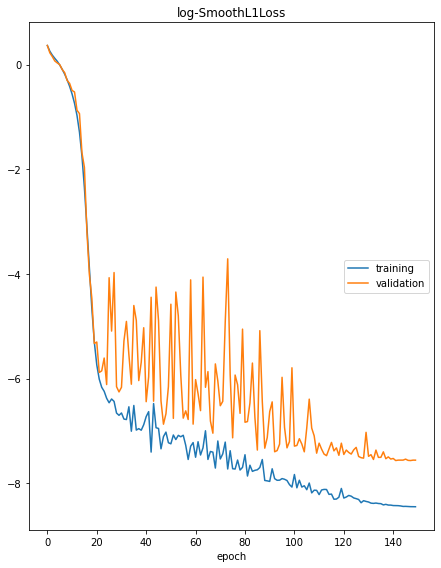

log-SmoothL1Loss
	training         	 (min:   -8.446, max:    0.363, cur:   -8.446)
	validation       	 (min:   -7.564, max:    0.364, cur:   -7.557)


In [126]:
metrics = m.fit(df_train, freq='D', validation_df=df_test, progress='plot')

In [127]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
149,0.000215,18.520987,27.878551,0.0,0.000523,34.471301,43.935048


### Forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.96% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.96% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


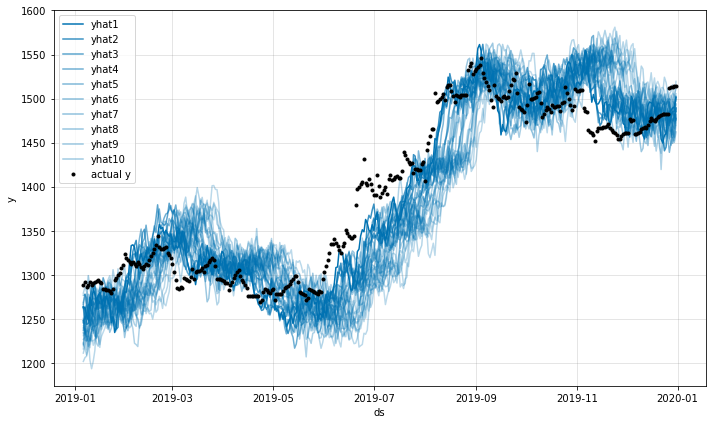

In [128]:
forecast = m.predict(df_test)
fig = m.plot(forecast[-360:])

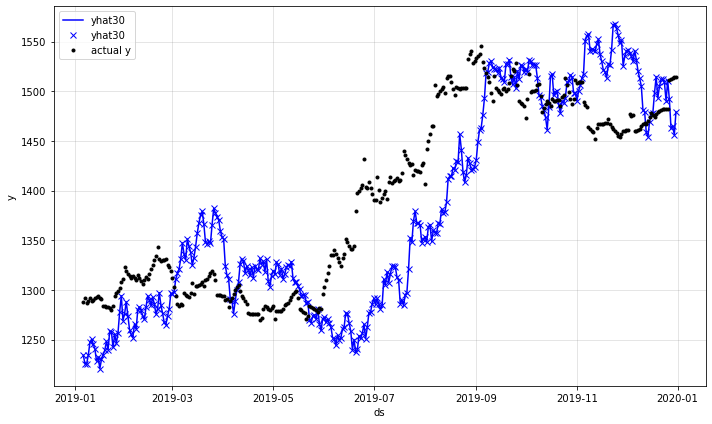

In [130]:
m = m.highlight_nth_step_ahead_of_each_forecast(30)
fig = m.plot(forecast[-360:])

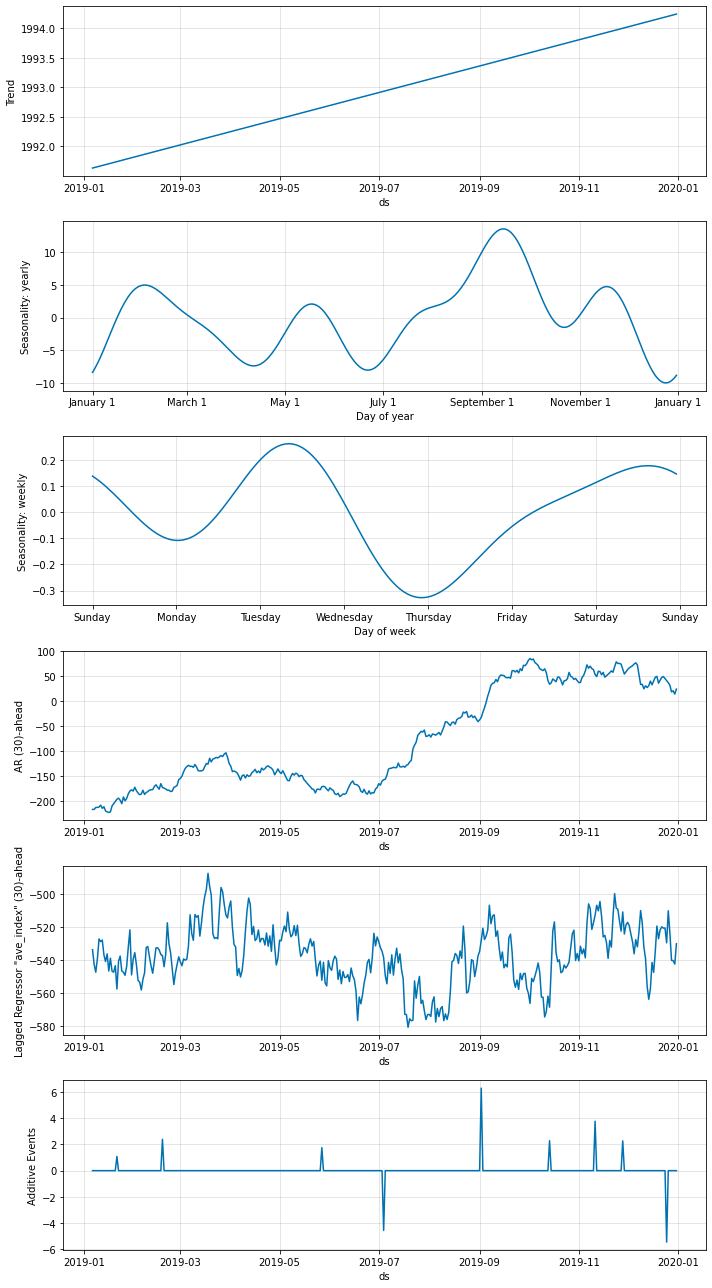

In [131]:
fig_comp = m.plot_components(forecast[-360:])

## Conclusion
---
As we saw in the above models, the data didn't necessarily lend itself well to a neural network architecture. In fact, the AR model did a better job than the neural model, and the addition of a lagged covariate as well as US holidays had minimal improvement on the error metrics and consequently on the quality of forecasts.

While one of the strengths of NeuralProphet is its ability to pre-select strong defaults for non-experts, some tuning of the hyperparameters would most likely improve results. Expert input, such as appropriate lagged covariates, may also improve results further.

## Other References
---
- [NeuralProphet Core Module Documentation](https://neuralprophet.com/html/forecaster.html?highlight=highlight_nth_step_ahead_of_each_forecast#neuralprophet.forecaster.NeuralProphet.highlight_nth_step_ahead_of_each_forecast)
- [NeuralProphet: Using Lagged Covariates](https://neuralprophet.com/html/lagged_covariates_energy_ercot.html)
- [NeuralProphet for Time-Series Forecasting: Predicting Stock Prices Using Facebook’s New Model](https://medium.com/mlearning-ai/neuralprophet-for-time-series-forecasting-predicting-stock-prices-using-facebooks-new-model-a88ca146261c)